### make_blobs

In [ ]:
# import required libraries
import torch
import sklearn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# setting up the device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)
print(torch.__version__)

cpu
2.2.1+cu121


In [ ]:
# get data from make_blobs
X, y = make_blobs(n_samples = 1000,
                  random_state = 42,
                  n_features = 2,
                  centers = 4,
                  cluster_std =2)
# putting the features and labels on the target device
X = torch.from_numpy(X).type(torch.float).to(device)
y = torch.from_numpy(y).type(torch.LongTensor).to(device)
print(X.shape, y.shape)

torch.Size([1000, 2]) torch.Size([1000])


In [ ]:
# sklearn.model_selection train_test_split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 42)

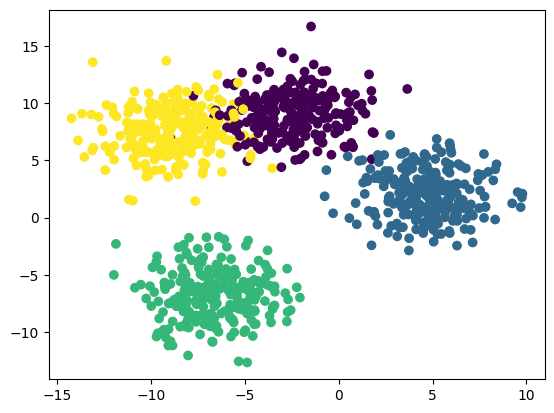

In [ ]:
# plotting the data
plt.scatter(x = X[:,0],
            y = X[:,1],
            c = y)

In [ ]:
# creating the model
class BlobModelV0(torch.nn.Module):
  def __init__(self, in_features, hidden_features, out_features):
    super().__init__()

    # layers and activation function
    self.layer_1 = torch.nn.Linear(in_features = in_features, out_features = hidden_features)
    self.layer_2 = torch.nn.Linear(in_features = hidden_features, out_features = hidden_features)
    self.layer_3 = torch.nn.Linear(in_features = hidden_features, out_features = out_features)
    self.activation = torch.nn.ReLU()

  def forward(self, x):
    return self.layer_3(self.activation(self.layer_2(self.activation(self.layer_1(x)))))

model_0 = BlobModelV0(in_features = 2, out_features = 4, hidden_features = 16).to(device)
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.2784, -0.5433],
                      [-0.1825,  0.5284],
                      [-0.6847,  0.3707],
                      [ 0.1669, -0.1205],
                      [ 0.2821, -0.2729],
                      [-0.3625, -0.3080],
                      [-0.5581, -0.6278],
                      [ 0.4900, -0.5978],
                      [ 0.3649,  0.4808],
                      [ 0.0768,  0.0729],
                      [ 0.0517,  0.5023],
                      [-0.3579, -0.1267],
                      [-0.3231, -0.6006],
                      [ 0.1393,  0.2651],
                      [-0.6366,  0.2159],
                      [-0.6170, -0.5583]])),
             ('layer_1.bias',
              tensor([-0.2181, -0.1072,  0.1970, -0.6888, -0.3206,  0.0339,  0.4043, -0.6509,
                      -0.0526,  0.0184,  0.0858,  0.5430, -0.5364, -0.0440, -0.6564, -0.6535])),
             ('layer_2.weight',
              tensor([[ 0.0465, -0.2003,

In [ ]:
!pip install torchmetrics

In [ ]:
from torchmetrics import Accuracy
accuracy_fn = Accuracy(task = 'multiclass', num_classes = 4).to(device)

In [ ]:
# loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params = model_0.parameters(),
                             lr = 0.1)

In [ ]:
y_train[0].dtype

torch.int64

In [ ]:
model_0.eval()
with torch.inference_mode():
  y_temp = model_0(X_train)

y_temp = torch.softmax(y_temp, dim = 1)
y_temp[0].dtype

torch.float32

In [ ]:
# building training and testing loop

epochs = 1000

for epoch in range(epochs):
  # put the model in training mode
  model_0.train()

  # forward pass
  y_pred_logits = model_0(X_train)
  y_softmax = torch.softmax(y_pred_logits, dim = 1)
  y_pred = torch.argmax(y_softmax, dim = 1)

  # calculating the loss and accuracy
  train_loss = loss_fn(y_pred_logits, y_train)
  train_accuracy = accuracy_fn(y_pred, y_train)

  # optimizer zero grad (gradient descent)
  optimizer.zero_grad()

  # loss backward (backpropagation)
  train_loss.backward()

  # optimizer step
  optimizer.step()

  # testing loop for every 100 epochs
  if epoch % 100 == 0:
    model_0.eval()
    with torch.inference_mode():
      y_eval_logits = model_0(X_test)
      y_eval_softmax = torch.softmax(y_eval_logits, dim = 1)
      y_eval = torch.argmax(y_eval_softmax, dim = 1)

      test_loss = loss_fn(y_eval_logits, y_test)
      test_accuracy = accuracy_fn(y_eval, y_test)

    print(f'epoch: {epoch} | train loss: {train_loss} | train accuracy: {train_accuracy} | test loss: {test_loss} | test accuracy: {test_accuracy}')

epoch: 0 | train loss: 1.782282829284668 | train accuracy: 0.004999999888241291 | test loss: 1.073506474494934 | test accuracy: 0.38999998569488525
epoch: 100 | train loss: 0.06658519059419632 | train accuracy: 0.9712499976158142 | test loss: 0.05055176839232445 | test accuracy: 0.9750000238418579
epoch: 200 | train loss: 0.0651865229010582 | train accuracy: 0.9737499952316284 | test loss: 0.04275815561413765 | test accuracy: 0.9850000143051147
epoch: 300 | train loss: 0.06626616418361664 | train accuracy: 0.9700000286102295 | test loss: 0.04406961053609848 | test accuracy: 0.9800000190734863
epoch: 400 | train loss: 0.06287676095962524 | train accuracy: 0.9712499976158142 | test loss: 0.04657232388854027 | test accuracy: 0.9800000190734863
epoch: 500 | train loss: 0.06270479410886765 | train accuracy: 0.9737499952316284 | test loss: 0.044139739125967026 | test accuracy: 0.9800000190734863
epoch: 600 | train loss: 0.06217527762055397 | train accuracy: 0.9725000262260437 | test loss: 0.

In [ ]:
import requests
from pathlib import Path

# Download helper function from Learn PyTorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py","wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


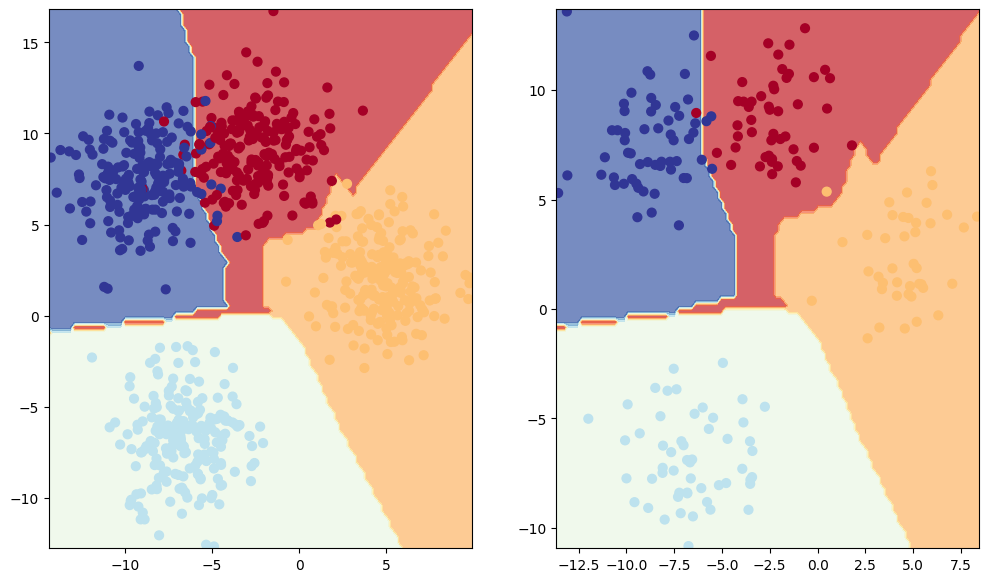

In [ ]:
plt.figure(figsize = (12,7))
plt.subplot(1,2,1)
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plot_decision_boundary(model_0, X_test, y_test)